# Принятие решения в бизнесе

В нашем распоряжении имеется список гипотез для увеличения выручки

Наша задача - проанализировать гипотезы, запустить A/B-тест и проанализировать результаты

**Описание данных:**

Структура hypothesis.csv:

* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Cтруктура orders.csv:

* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.

Cтруктура visitors.csv:

* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста


In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from pandas.plotting import register_matplotlib_converters
import warnings

**Загрузка данных:**

In [2]:
try:
    df = pd.read_csv('/datasets/hypothesis.csv').copy()
except:
    df = pd.read_csv('C:/Users/jerno/PycharmProjects/sds2/Data/hypothesis.csv').copy()
try:
    orders = pd.read_csv('/datasets/orders.csv').copy()
except:
    orders = pd.read_csv('C:/Users/jerno/PycharmProjects/sds2/Data/orders.csv').copy()
try:
    visitors = pd.read_csv('/datasets/visitors.csv').copy()
except:
    visitors = pd.read_csv('C:/Users/jerno/PycharmProjects/sds2/Data/visitors.csv').copy()

## Часть 1. Приоритизация гипотез

In [3]:
df.columns = map(str.lower, df.columns)

### Применение фреймворка ICE

In [4]:
df['ice']= (df['impact']*df['confidence'])/df['efforts']
df[['hypothesis','ice']].sort_values(by='ice',ascending=False)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день...",16.200000
0,"Добавить два новых канала привлечения трафика,...",13.333333
7,Добавить форму подписки на все основные страни...,11.200000
6,Показать на главной странице баннеры с актуаль...,8.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,7.000000
1,"Запустить собственную службу доставки, что сок...",2.000000
5,"Добавить страницу отзывов клиентов о магазине,...",1.333333
3,"Изменить структура категорий, что увеличит кон...",1.125000
4,"Изменить цвет фона главной страницы, чтобы уве...",1.000000


### Применение фреймворка RICE

In [5]:
df['rice']=(df['reach']*df['impact']*df['confidence'])/df['efforts']
df[['hypothesis','rice']].sort_values(by='rice',ascending=False)

,hypothesis,rice
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


**Вывод:**
* заметим, что при вычислении RICE, относительно ICE, числитель ещё умножается на "reach". Это нам показывает, что значение RICE может быть в несколько раз больше значения ICE
* значение "reach" влияет на приоритезацию гипотез

# Часть 2. Анализ A/B-теста

In [6]:
orders['date']= pd.to_datetime(orders['date'], format='%Y/%m/%d')
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y/%m/%d')

<div class="alert alert-info">

Исследование качества данных  

</div>

## Исследование качества данных

### Подсчёт групп в AB-тесте

**В AB тесте учавствуют две группы**

### Подсчёт пользователей в каждой группе

**До удаления дубликатов:**

In [7]:
orders['group'].value_counts()

B    640
A    557
Name: group, dtype: int64

In [8]:
visitors['group'].value_counts()

B    31
A    31
Name: group, dtype: int64

### Минимальная и максимальная даты исследования

In [9]:
orders['date'].min()

Timestamp('2019-08-01 00:00:00')

In [10]:
orders['date'].max()

Timestamp('2019-08-31 00:00:00')

### Проверка на попадание пользователей в обе группы

In [11]:
orders.groupby('visitorId').agg({'group' : 'nunique'}).query('group>1').count()

group    58
dtype: int64

**Как видим, имеются пользователи, которые попадают в обе группы. Удалим данные дубликаты**

In [12]:
double=orders.groupby('visitorId').agg({'group' : 'nunique'}).reset_index().query('group>1')['visitorId'].unique()

In [13]:
orders = orders.query('visitorId not in @double')
orders['group'].value_counts()

B    548
A    468
Name: group, dtype: int64

### Проверка данных на наличие пропусков и дубликатов

In [14]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1016 non-null   int64         
 1   visitorId      1016 non-null   int64         
 2   date           1016 non-null   datetime64[ns]
 3   revenue        1016 non-null   int64         
 4   group          1016 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


In [15]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [16]:
orders[['date','group']].duplicated().sum()

954

**Пропуски отсутствуют, но имеются дубликаты. В дальнейшем мы их удалим.**

## Построение графика кумулятивной выручки по группам

In [17]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates() 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


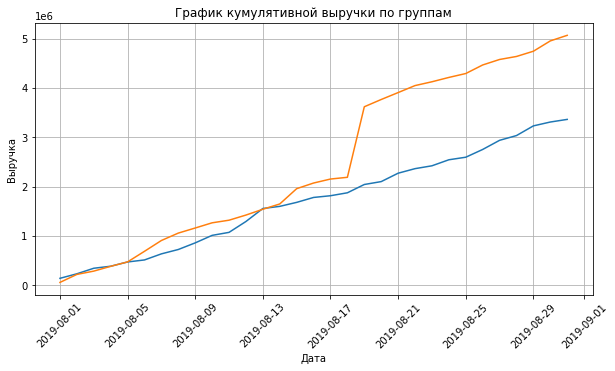

In [18]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]


# Строим график выручки группы А
plt.figure(figsize=(10,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('График кумулятивной выручки по группам')
plt.grid(True)
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.show()

**Вывод:**
* как видим в начале выручка равномерно увеличивалась, однако в некоторых точнах произошли скачки, которые привели к тому, что выручка группы B примерно в 2 раза возрасла
* это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

## Построение графика кумулятивного среднего чека по группам.

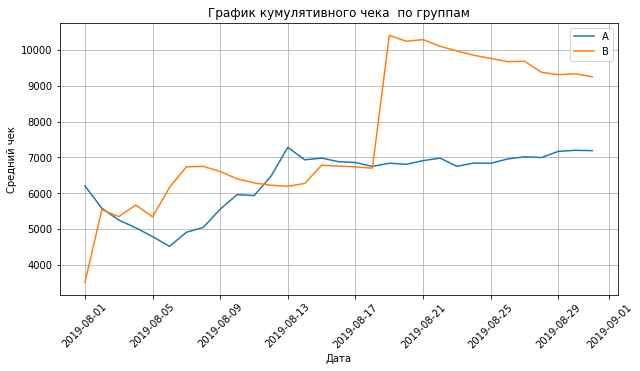

In [19]:
plt.figure(figsize=(10,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('График кумулятивного чека  по группам')
plt.grid(True)
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.legend() 
plt.show()

**Вывод:**
* обе группы изначально претерпевают скачки: группа А в худшую сторону, а В - в лучшую
* в  2019-08-13 выручка групп становится одинаковой
* после 2019-08-13 выручка группы В претерпевает резкий рост , посде 2019-08-13 выручка группы А имеет равномерный характер

## Построение графика относительного изменения кумулятивного среднего чека группы B к группе A

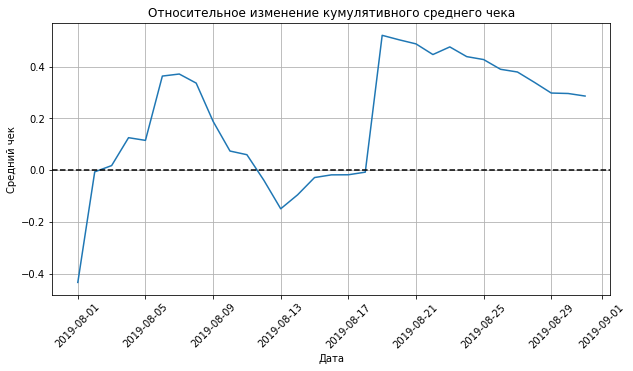

In [20]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(10,5))
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.grid(True)
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.xticks(rotation=45)
plt.title('Относительное изменение кумулятивного среднего чека')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.show()

**Вывод:**
* В нескольких точках график различия между сегментами резко «скачет»
* Можно сделать предположение, что где-то уж точно спрятались крупные заказы и выбросы

## Построение графика кумулятивного среднего количества заказов на посетителя по группам

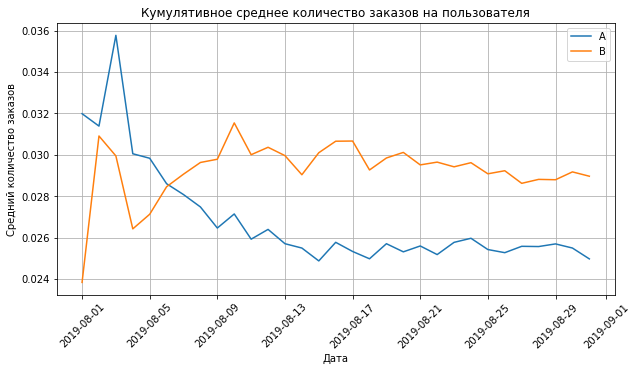

In [21]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']
plt.figure(figsize=(10,5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.grid(True)
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Средний количество заказов')
plt.legend()
plt.title('Кумулятивное среднее количество заказов на пользователя')
plt.show()


**Вывод:**
* средний чек претерпевает резкие скачки в начальных датах( среднее количество заказов увеличилось)
* как видим, после скачка у обеих групп среднее количество уменьшилось; у группы B в определённый момент наблюдается резкое увеличение среднего чека, после чего среднее количество "устаканивается" и принимает равномерный характер
* группа А после своего падения "устаканивается" и принимает равномерный характер

## Построение графика относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

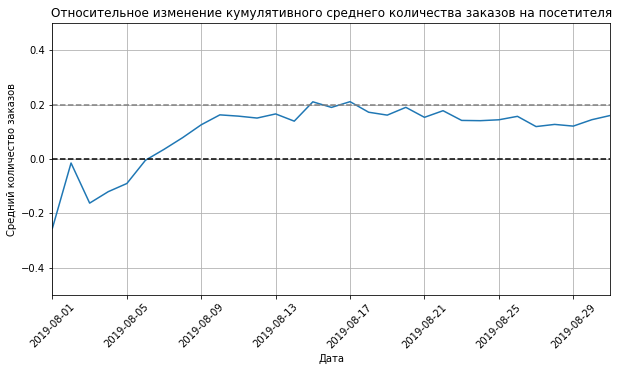

In [22]:
register_matplotlib_converters()


datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': 'nunique',
            'visitorId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

cumulativeData['conversion'] = (
    cumulativeData['orders'] / cumulativeData['visitors']
)

cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']




mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(10,5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
plt.grid(True)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.5, 0.5])
plt.xticks(rotation=45)
plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя')
plt.xlabel('Дата')
plt.ylabel('Средний количество заказов')
plt.show()

**Вывод:**
* как видим,кумулятивное среднее для группы В изначально проигрывает группу А
* вскоре значение для В вырывается вперёд; позже конверсия группы А вырывается вперёд

## Построение точечного графика количества заказов по пользователям

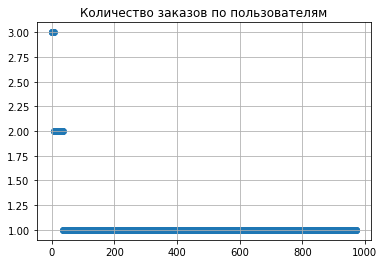

In [23]:
orders_by_users = orders.groupby('visitorId', as_index = False).agg({'transactionId':'nunique'}).sort_values(by='transactionId', ascending = False)
orders_by_users.columns = ['visitorId', 'orders']

x_values=pd.Series(range(0,len(orders_by_users)))
plt.scatter(x_values,orders_by_users['orders'])
plt.title('Количество заказов по пользователям')
plt.grid(True)
plt.show()                                                    
                                                                   

In [24]:
orders_by_users['orders'].value_counts().to_frame()

,orders
1,937
2,29
3,7


**Вывод:**
* 937 пользователей сделали по одному заказу
* 29 пользователей сделали по два заказа
* 7 пользователей сделали по 7 заказов

## Подсчёт 95-й и 99-й перцентилей количества заказов на пользователя

In [25]:
orders_by_users.head()

,visitorId,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3


In [26]:
np.percentile(orders_by_users['orders'],[95, 99])

array([1., 2.])

**Вывод:**
* меньше или равняется 5% пользователей с количеством заказов 2 
* меньше или равняется 1% пользователей с количеством заказа 1 

## Построение точечного графика стоимостей заказов

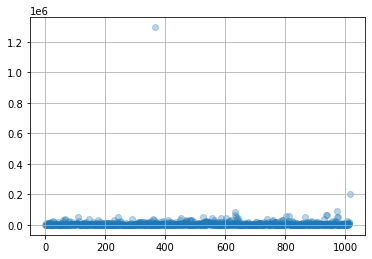

In [27]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'],alpha=0.3) 
plt.grid(True)
plt.show()

In [28]:
orders['revenue'].sort_values(ascending=False).to_frame()

,revenue
425,1294500
1196,202740
1136,92550
744,86620
743,67990
...,...
404,70
933,60
584,50
756,50


**Вывод:**
* имеются два дорогих заказа: на 1294500 и на 202740
* основные значения стоимости заказов лежат в интервале (50;92550)

## Подсчёт 95-й и 99-й перцентилей стоимости заказов 

In [29]:
orders['revenue']
np.percentile(orders['revenue'],[95, 99])

array([26785., 53904.])

**Вывод:**
* меньше или равняется 5% заказов дороже 26785
* меньше или равняется 1% заказов дороже 53904

<div class="alert alert-info">

Определение границ выбросов

</div>

* Найденные в прошлых пунктах 95-й и 99-й перцентили средних чеков равны 26785 и 53904 рублям. А 95-й и 99-й перцентили количества заказов на одного пользователя равны 1 и 2 заказа на пользователя
* Примем за аномальных пользователей тех, кто совершил от 1 заказов или совершил заказ дороже 27000 рублей

## Подсчёт статистической значимости различий в среднем количестве заказов на посетителя по «сырым» данным

In [30]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5)) 

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              23           142779              17   
1 2019-08-02              19            91602              23   
2 2019-08-03              24           112473              14   
3 2019-08-04              11            41176              14   
4 2019-08-05              22            86383              21   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0            59758                  23               142779   
1           162043                  42               234381   
2            67049                  66               346854   
3            96890                  77               388030   
4            89908                  99               474413   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  17                59758               719   
1                  40               221801               619   
2                  54               28

In [31]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 

In [32]:
pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')
[ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')]
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

In [33]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
 

**Постановка гипотез**

* H_0: Cтатистически значимых различий в среднем количестве заказов между группами по "сырым" данным нет
* H_a: Имеются статистически значимые различия в среднем количестве заказов между группами по "сырым" данным 

In [34]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.011
0.160


**Вывод:**
* H_0 не отвергаем
* по «сырым» данным имеются различия в среднем числе заказов групп A и B 
* так как первое число — p-value = 0.011 < 0.05, то нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет,  отвергаем.  Относительный проигрыш группы B равен 16% — второе число в выводе.

## Подсчёт статистической значимости различий в среднем чеке заказа между группами по «сырым» данным

**Постановка гипотез**

* H_0: Cтатистически значимых различий в среднем чеке заказов между группами по "сырым" данным нет
* H_a: Имеются статистически значимые различия в среднем чеке заказов между группами по "сырым" данным 

In [35]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.829
0.287


**Вывод:**
* H_0 отвергаем
* по «сырым» данным имеются различия в среднем чеке заказов групп A и B 
* так как первое число — p-value = 0.829 > 0.05, то нулевую гипотезу отвергаем
* средний чек группы B значительно ниже среднего чека группы A

## Подсчёт статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

* Найденные в прошлых пунктах 95-й и 99-й перцентили средних чеков равны 28000 и 58233 рублям. А 95-й и 99-й перцентили количества заказов на одного пользователя равны 2 и 4 заказа на пользователя
* Примем за аномальных пользователей тех, кто совершил от 2 заказов или совершил заказ дороже 28000 рублей

In [36]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 1]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 1]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 27000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0]) 

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
Name: visitorId, dtype: int64
86


**Постановка гипотез**

* H_0: Cтатистически значимых различий в среднем числе заказов между группами по "сырым" данным нет
* H_a: Имеются статистически значимые различия в среднем числе заказов между группами по "сырым" данным

In [37]:
print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

NameError: name 'sampleAFiltered' is not defined

**Вывод:**
* было для А : 0.017 ; для В:0.138
* стало для А : 0.009 ; для B:0.189
* как видим, результаты по среднему количеству заказов практически не изменились
* H_0 не отвергаем
* p-value=0.009 < 0.05 , то нулевую гипотезу не отвергаем

##  Подсчёт статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным.

**Постановка гипотез**

* H_0: Cтатистически значимых различий в среднем чеке заказов между группами по "очищенным" данным нет
* H_a: Имеются статистически значимые различия в среднем числе заказов между группами по "очищенным" данным

In [ ]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

**Вывод:**
* было для А : 0.729 ; для В: 0.259
* стало для А : 0.727 ; для B: -0.034
* как видим, p-value для А практически не изменилось , а для В - уменьшилось на 0,293
* H_0 отвергаем, принимаем альтернативную гипотезу H_a
* p-value=0.727>0.05, отвергаем нулевую гипотезу


# Принятие решений по результатам теста

**Общий вывод:**

* Основываясь на значениях графика кумулятивного среднего чека по группам и графика относительного изменения кумулятивного среднего чека группы B к группе A, можно прийти к выводу, что группа B стабильно лучше группы A по конверсии

* Остановить тест, зафиксировать победу группы В
